In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('robot_dataset.csv')
print("--- Data Exploration: First 5 Rows ---")
print(df.head())
    
print("\n--- Data Information: Columns, Non-Null Counts, Dtypes ---")
df.info()
    
print("\n--- Descriptive Statistics for Numerical Columns ---")
print(df.describe())
    
if 'Task_Type' in df.columns:
    print("\n--- Value Counts for 'Task_Type' (States of the Markov Chain) ---")
    print(df['Task_Type'].value_counts())
        


--- Data Exploration: First 5 Rows ---
  Robot_ID   Task_Type Component_ID Sensor_Type            Sensor_Data  \
0  RBT_001  Inspection      CMP_460       LIDAR  1 (obstacle detected)   
1  RBT_002    Assembly      CMP_252     Thermal              85.3 (°C)   
2  RBT_003  Inspection      CMP_248     Thermal       92% (visual fit)   
3  RBT_004     Welding      CMP_433      Camera      98% (defect-free)   
4  RBT_005    Assembly      CMP_992      Camera       92% (visual fit)   

   Processing_Time (s)  Accuracy (%) Environmental_Status  \
0                 67.0          90.4               Stable   
1                 71.2          98.1               Stable   
2                 49.2          95.3             Unstable   
3                 74.5          90.2               Stable   
4                 64.5          97.2             Unstable   

   Energy_Consumption (kWh) Human_Intervention_Needed Obstacle_Detected  \
0                       2.2                        No               Yes   

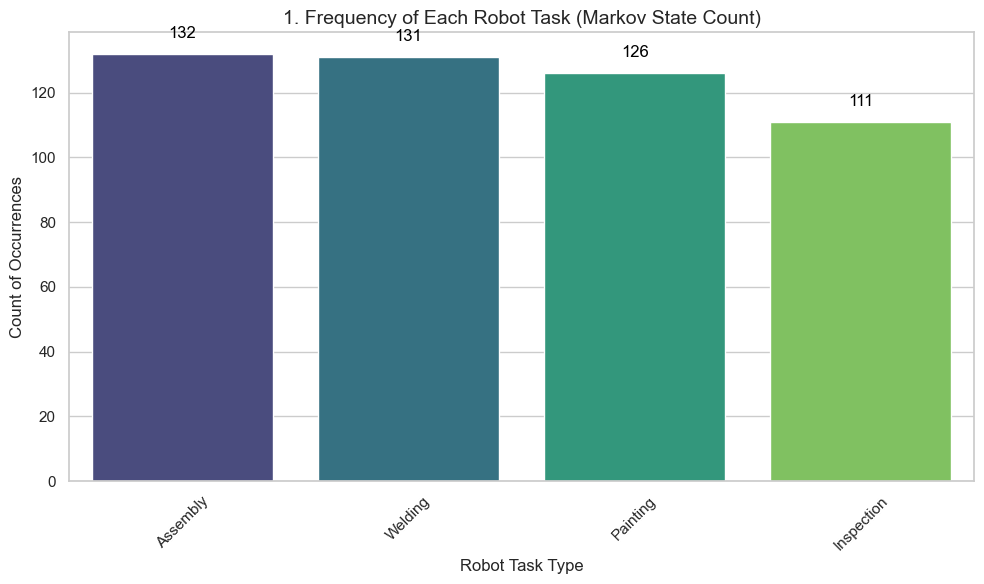

In [21]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) 



plt.figure(figsize=(10, 6))
task_counts = df['Task_Type'].value_counts().sort_values(ascending=False)
ax = sns.barplot(x=task_counts.index, y=task_counts.values, hue=task_counts.index, palette="viridis", legend=False)

ax.set_title('1. Frequency of Each Robot Task (Markov State Count)', fontsize=14)
ax.set_xlabel('Robot Task Type')
ax.set_ylabel('Count of Occurrences')
plt.xticks(rotation=45)

# Add bar labels
for i, v in enumerate(task_counts.values):
    ax.text(i, v + 5, str(v), color='black', ha='center')

plt.tight_layout()
plt.show()
    

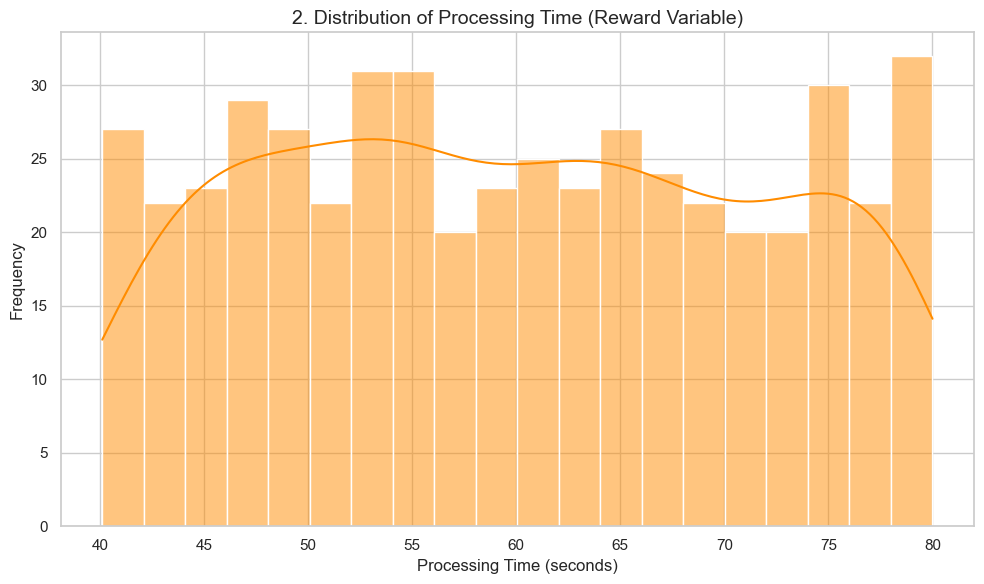

In [22]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) 


plt.figure(figsize=(10, 6))
sns.histplot(df['Processing_Time (s)'], kde=True, color="darkorange", bins=20)

plt.title('2. Distribution of Processing Time (Reward Variable)', fontsize=14)
plt.xlabel('Processing Time (seconds)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
    


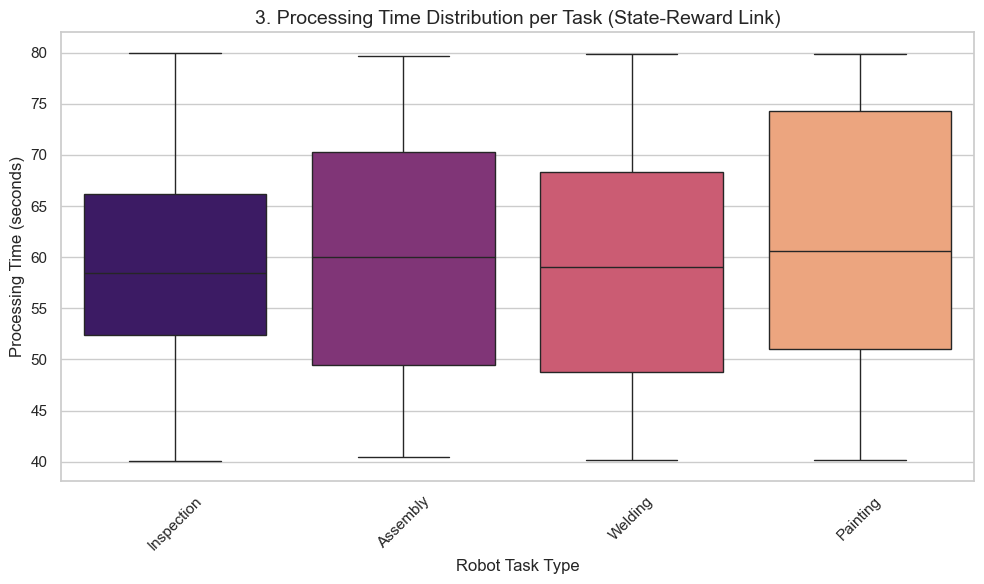

In [23]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) 

plt.figure(figsize=(10, 6))
sns.boxplot(x='Task_Type', y='Processing_Time (s)', data=df, hue='Task_Type', palette="magma", legend=False)

plt.title('3. Processing Time Distribution per Task (State-Reward Link)', fontsize=14)
plt.xlabel('Robot Task Type')
plt.ylabel('Processing Time (seconds)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


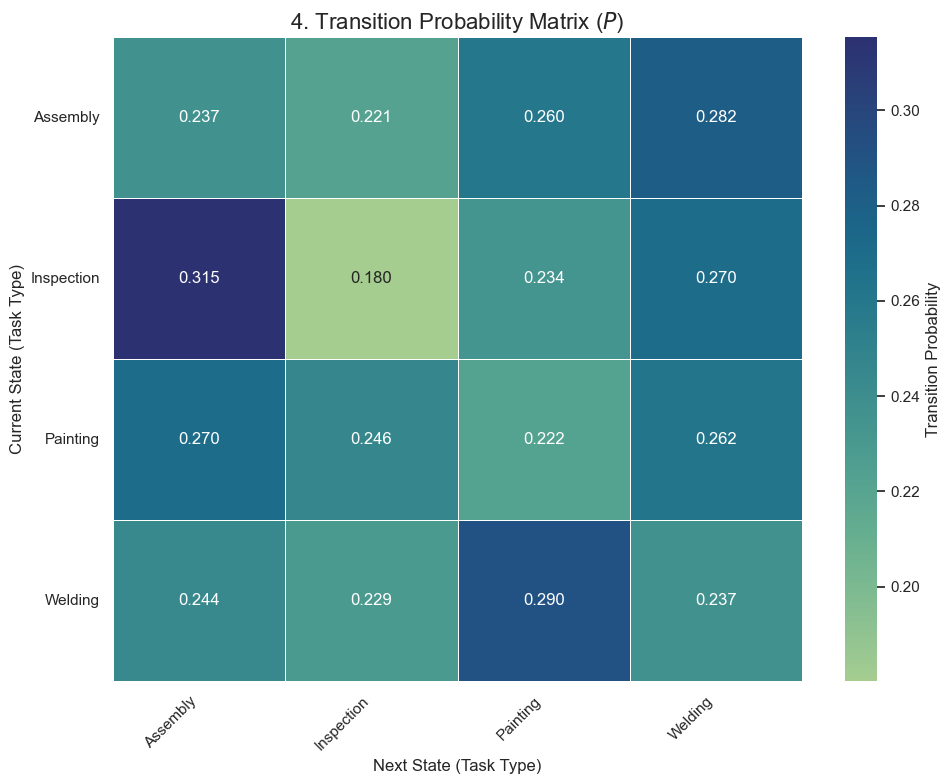

In [24]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 8) 

transition_df = df[['Task_Type']].copy()
transition_df['Next_Task'] = transition_df['Task_Type'].shift(-1)
transition_df.dropna(inplace=True) 

transition_counts = pd.crosstab(
    transition_df['Task_Type'], 
    transition_df['Next_Task'], 
    normalize='index' 
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    transition_counts, 
    annot=True, 
    fmt=".3f", 
    cmap="crest", 
    linewidths=.5, 
    cbar_kws={'label': 'Transition Probability'}
)

plt.title('4. Transition Probability Matrix ($P$)', fontsize=16)
plt.xlabel('Next State (Task Type)')
plt.ylabel('Current State (Task Type)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()



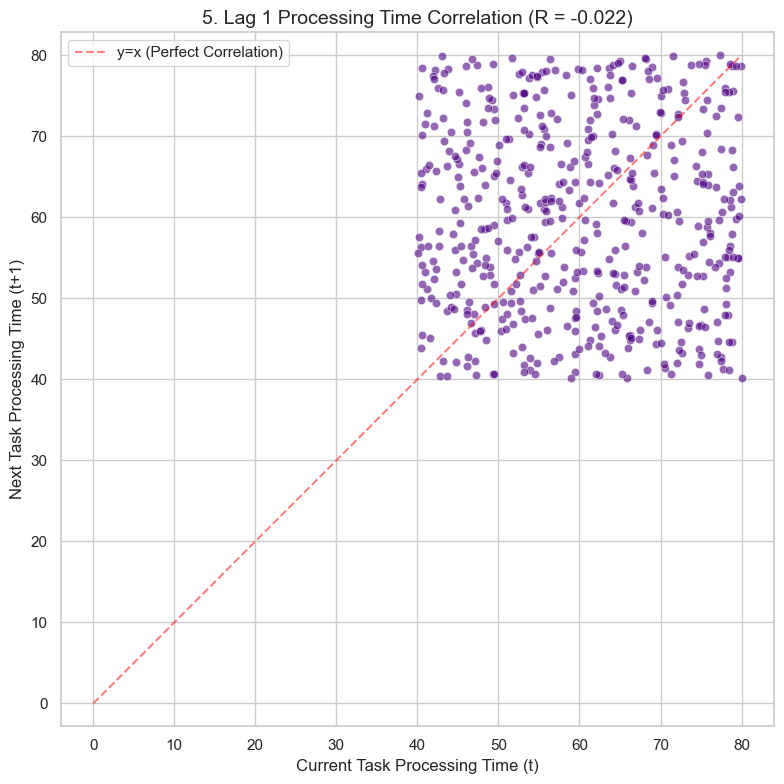

In [25]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 8) 



lag_df = df[['Processing_Time (s)']].copy()
lag_df['Next_Time (s)'] = lag_df['Processing_Time (s)'].shift(-1)
lag_df.dropna(inplace=True) 

correlation = lag_df['Processing_Time (s)'].corr(lag_df['Next_Time (s)'])

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x='Processing_Time (s)', 
    y='Next_Time (s)', 
    data=lag_df, 
    alpha=0.6, 
    color="indigo"
)

plt.title(f'5. Lag 1 Processing Time Correlation (R = {correlation:.3f})', fontsize=14)
plt.xlabel('Current Task Processing Time (t)')
plt.ylabel('Next Task Processing Time (t+1)')

max_val = lag_df[['Processing_Time (s)', 'Next_Time (s)']].max().max()
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', alpha=0.5, label='y=x (Perfect Correlation)')
plt.legend()
plt.axis('equal') 

plt.tight_layout()
plt.show()


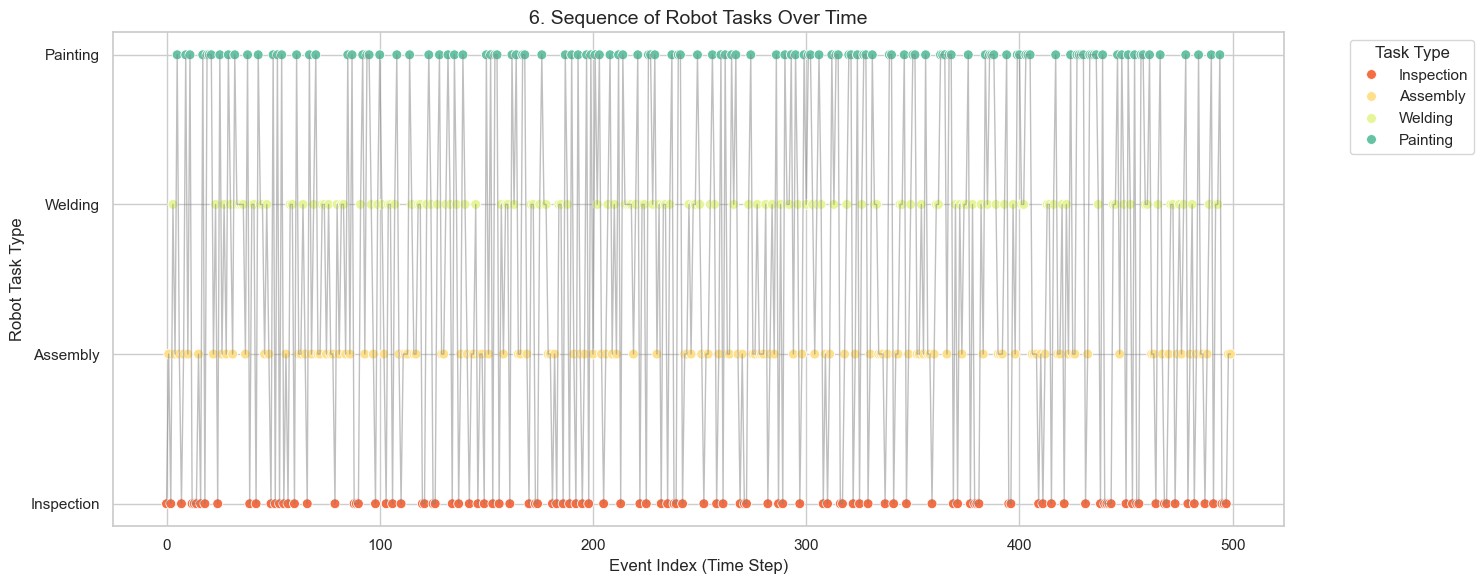

In [26]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6) 


unique_tasks = df['Task_Type'].unique()
task_mapping = {task: i for i, task in enumerate(unique_tasks)}
df['Task_Code'] = df['Task_Type'].map(task_mapping)

plt.figure(figsize=(15, 6))

sns.scatterplot(
    x=df.index, 
    y='Task_Code', 
    data=df, 
    hue='Task_Type', 
    palette="Spectral", 
    legend=True, 
    s=50
)

plt.plot(df.index, df['Task_Code'], linestyle='-', alpha=0.5, linewidth=1, color='gray')

plt.title('6. Sequence of Robot Tasks Over Time', fontsize=14)
plt.xlabel('Event Index (Time Step)')
plt.ylabel('Robot Task Type')

plt.yticks(list(task_mapping.values()), list(task_mapping.keys()))

plt.legend(title='Task Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [27]:
df = pd.read_csv('robot_dataset.csv')
task_sequence = df['Task_Type']

STATES = task_sequence.unique()
NUM_STATES = len(STATES)
print(f"States identified: {STATES}")

df_transitions = pd.DataFrame({
    'Current': task_sequence.iloc[:-1].values, 
    'Next': task_sequence.iloc[1:].values
})

frequency_matrix = pd.crosstab(df_transitions['Current'], df_transitions['Next'])

P_matrix = frequency_matrix.div(frequency_matrix.sum(axis=1), axis=0)

print("\n--- Calculated Transition Matrix (P) from Real Data ---")
print(P_matrix.round(4))

States identified: ['Inspection' 'Assembly' 'Welding' 'Painting']

--- Calculated Transition Matrix (P) from Real Data ---
Next        Assembly  Inspection  Painting  Welding
Current                                            
Assembly      0.2366      0.2214    0.2595   0.2824
Inspection    0.3153      0.1802    0.2342   0.2703
Painting      0.2698      0.2460    0.2222   0.2619
Welding       0.2443      0.2290    0.2901   0.2366


In [28]:

P_array = P_matrix.values 
NUM_STATES = len(STATES)


A = P_array.T - np.identity(NUM_STATES)
A[-1, :] = 1.0  

b = np.zeros(NUM_STATES)
b[-1] = 1.0

try:
    pi = np.linalg.solve(A, b)
    
    steady_state_df = pd.DataFrame(pi, index=STATES, columns=['Steady-State Probability'])
    
    print("\n--- Long-Term Steady-State Distribution (pi) ---")
    print(steady_state_df.round(4))
    print(f"\nTotal probability check: {pi.sum().round(9)}")
    
except np.linalg.LinAlgError:
    print("\nError: The Markov Chain may be reducible (not all states are reachable).")


--- Long-Term Steady-State Distribution (pi) ---
            Steady-State Probability
Inspection                    0.2644
Assembly                      0.2205
Welding                       0.2526
Painting                      0.2625

Total probability check: 1.0


In [29]:
N = 5

P_N = np.linalg.matrix_power(P_array, N)

print(f"\n--- {N}-Step Transition Matrix (P^{N}) ---")
P_N_df = pd.DataFrame(P_N, index=STATES, columns=STATES)
print(P_N_df.round(11))


--- 5-Step Transition Matrix (P^5) ---
            Inspection  Assembly   Welding  Painting
Inspection    0.264380  0.220522  0.252552  0.262546
Assembly      0.264379  0.220522  0.252553  0.262546
Welding       0.264379  0.220521  0.252553  0.262547
Painting      0.264380  0.220521  0.252552  0.262547


In [30]:

TIME_COLUMN = 'Processing_Time (s)' 

state_rewards_R = df.groupby('Task_Type')[TIME_COLUMN].mean().reindex(STATES)

print(f"\n--- Average {TIME_COLUMN} (Reward Vector R) ---")
print(state_rewards_R.round(2))


expected_processing_time_per_task = np.dot(pi, state_rewards_R.values)

print("\n--- Expected Long-Term Processing Time per Task Cycle ---")
print(f"The long-term average duration of one complete task cycle is: {expected_processing_time_per_task:.2f} seconds.")


--- Average Processing_Time (s) (Reward Vector R) ---
Task_Type
Inspection    58.80
Assembly      60.19
Welding       59.08
Painting      61.57
Name: Processing_Time (s), dtype: float64

--- Expected Long-Term Processing Time per Task Cycle ---
The long-term average duration of one complete task cycle is: 59.90 seconds.


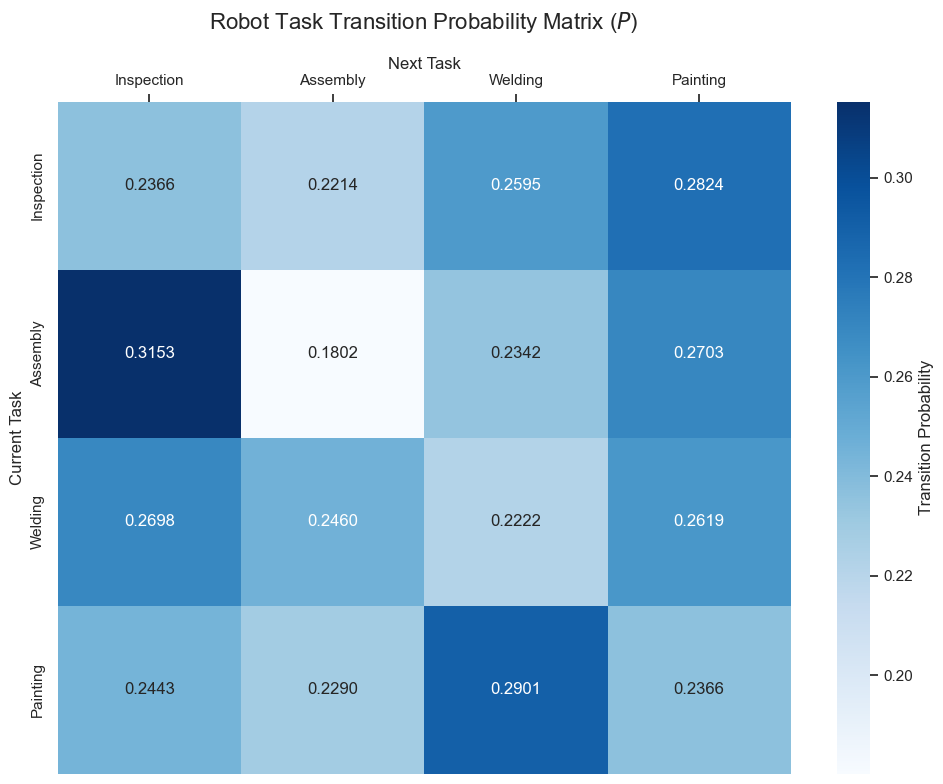

In [31]:
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(10, 8))
ax = sns.heatmap(P_matrix, annot=True, cmap="Blues", fmt=".4f",
            xticklabels=STATES, yticklabels=STATES,
            cbar_kws={'label': 'Transition Probability'})

plt.title('Robot Task Transition Probability Matrix ($P$)', fontsize=16, pad=20)

ax.xaxis.tick_top()                
ax.xaxis.set_label_position('top')  

plt.xlabel('Next Task', fontsize=12)
plt.ylabel('Current Task', fontsize=12)
plt.tight_layout()
plt.savefig('transition_heatmap.png', dpi=300)
plt.show()  

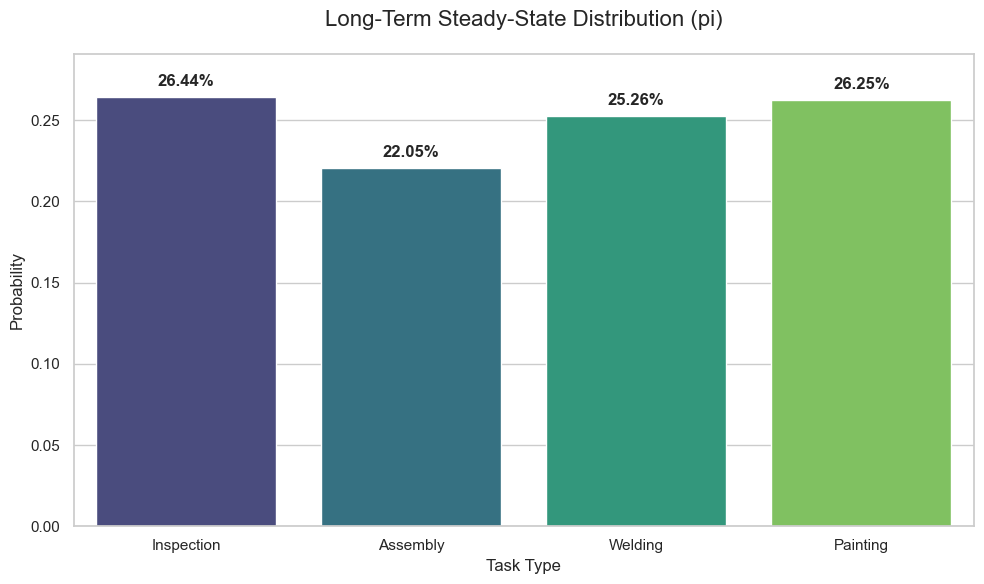

In [32]:
y_values = steady_state_df['Steady-State Probability']

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=STATES, y=y_values, hue=STATES, palette="viridis", dodge=False)

if barplot.legend_: barplot.legend_.remove() 

plt.title('Long-Term Steady-State Distribution (pi)', fontsize=16, pad=20)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Task Type', fontsize=12)

max_prob = y_values.max()
plt.ylim(0, max_prob * 1.1)


for i, v in enumerate(y_values):
    barplot.text(i, v + 0.005, f'{v:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('steady_state_distribution.png', dpi=300)
plt.show()

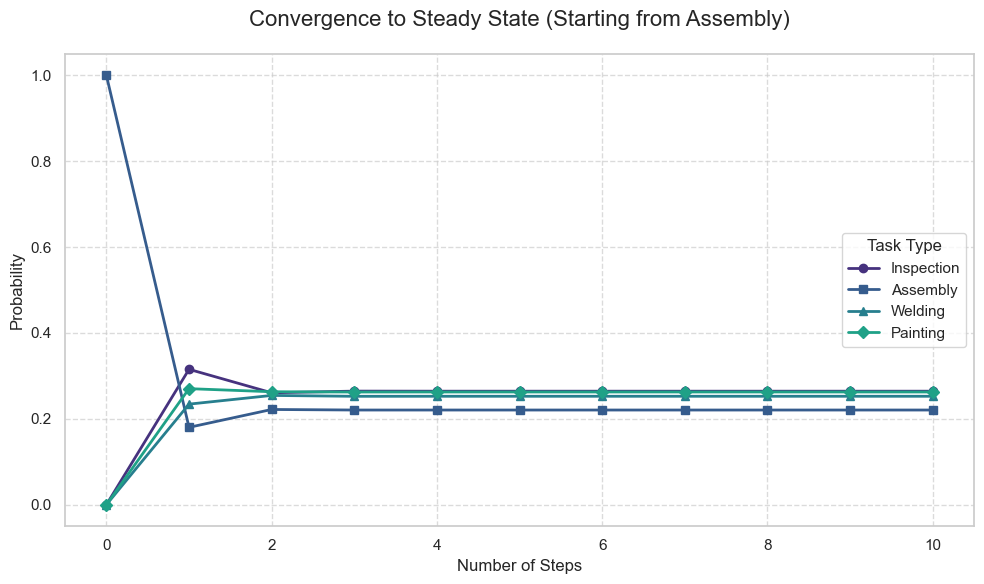

In [ ]:
steps = 10
history = np.zeros((steps + 1, NUM_STATES))

current_state = np.zeros(NUM_STATES)


start_index = np.where(STATES == 'Assembly')[0][0]
current_state[start_index] = 1.0

history[0] = current_state

for i in range(1, steps + 1):
    current_state = np.dot(current_state, P_array) 
    history[i] = current_state

plt.figure(figsize=(10, 6))
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p']

for i, state in enumerate(STATES):
    plt.plot(range(steps + 1), history[:, i], label=state, 
             marker=markers[i % len(markers)], linewidth=2)

plt.title('Convergence to Steady State (Starting from Assembly)', fontsize=16, pad=20)
plt.xlabel('Number of Steps', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend(title="Task Type", loc='center right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('convergence_plot.png', dpi=300)
plt.show()

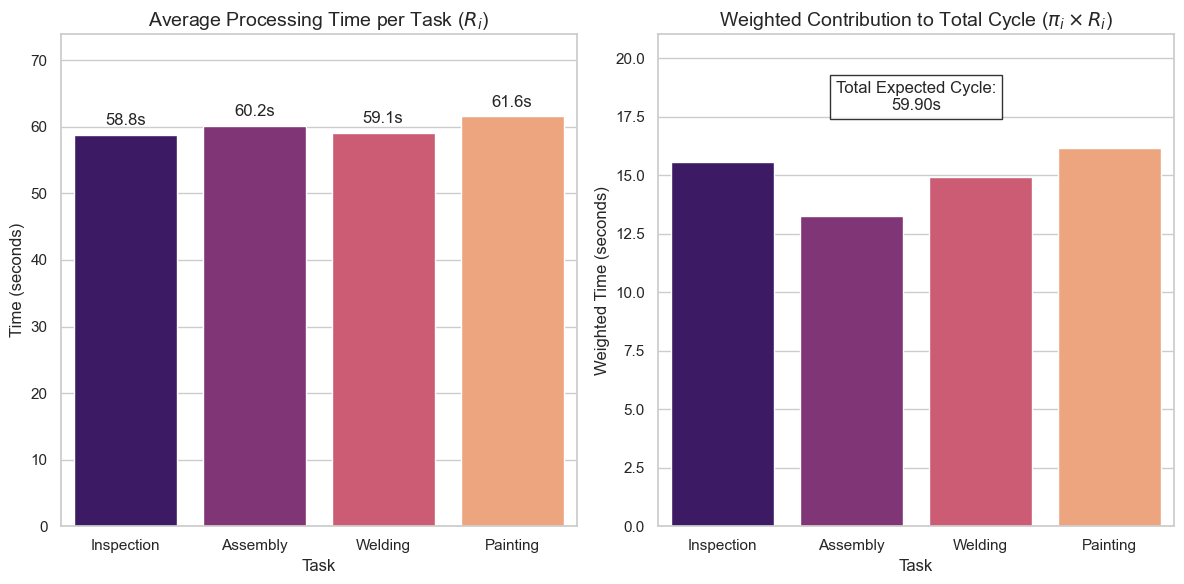

In [34]:
R_values = state_rewards_R.values  
pi_values = pi                     

mrp_df = pd.DataFrame({
    'Task': STATES,
    'Avg Time (s)': R_values,
    'Contribution (s)': pi_values * R_values
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bp1 = sns.barplot(x='Task', y='Avg Time (s)', data=mrp_df, hue='Task', palette="magma", dodge=False)
if bp1.legend_: bp1.legend_.remove()

plt.title(r'Average Processing Time per Task ($R_i$)', fontsize=14) 
plt.ylabel('Time (seconds)')
plt.ylim(0, R_values.max() * 1.2) 

for i, v in enumerate(R_values):
    plt.text(i, v + 1, f'{v:.1f}s', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bp2 = sns.barplot(x='Task', y='Contribution (s)', data=mrp_df, hue='Task', palette="magma", dodge=False)
if bp2.legend_: bp2.legend_.remove()

plt.title(r'Weighted Contribution to Total Cycle ($\pi_i \times R_i$)', fontsize=14)
plt.ylabel('Weighted Time (seconds)')
plt.ylim(0, mrp_df['Contribution (s)'].max() * 1.3) 

total_expected = mrp_df['Contribution (s)'].sum()

plt.text(1.5, mrp_df['Contribution (s)'].max() * 1.1, 
         f'Total Expected Cycle:\n{total_expected:.2f}s', 
         ha='center', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.savefig('mrp_analysis.png', dpi=300)
plt.show()